In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"datasets/CSVs/{dataset_files[index]}"

    with open(read_file, "r") as f:
        lines = f.readlines()

    lines[0] = lines[0].replace(", ", ",")

    with open(read_file, "w") as f:
        f.writelines(lines)

    df_read = pd.read_csv(read_file)
    pattern = r'[^\w\s]'
    df_read['Label'] = df_read['Label'].replace(pattern, '', regex=True)
    df_read.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df_read

df0 = dataset_file_to_df(0, files)
df1 = dataset_file_to_df(1, files)
df2 = dataset_file_to_df(2, files)
df3 = dataset_file_to_df(3, files)
df4 = dataset_file_to_df(4, files)
df5 = dataset_file_to_df(5, files)
df6 = dataset_file_to_df(6, files)
df7 = dataset_file_to_df(7, files)

df1 = df1[df1["Label"] != "BENIGN"]
df2 = df2[df2["Label"] != "BENIGN"]
df3 = df3[df3["Label"] != "BENIGN"]
df4 = df4[df4["Label"] != "BENIGN"]
df5 = df5[df5["Label"] != "BENIGN"]
df6 = df6[df6["Label"] != "BENIGN"]
df7 = df7[df7["Label"] != "BENIGN"]

df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7], axis=0, ignore_index=True)


In [ ]:
def normalize(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df_norm = df.copy()
    for col in numeric_columns:
        if df[col].skew() > 0:
            df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
        elif df[col].skew() < 0:
            df_norm[col] = df[col] ** 2  # Can cause overflow
    return df_norm

df_norm = normalize(df)
df_norm = df_norm[df_norm['Label'] != "Heartbleed"]
df_norm = df_norm[df_norm['Label'] != "Infiltration"]
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'DoS' if x.startswith('DoS') else x)
df_norm['Label'] = df_norm['Label'].apply(lambda x: 'WebAttack' if x.startswith('Web Attack') else x)


In [4]:
X = df_norm.drop(["Flow ID", "Src IP", "Timestamp", "Dst IP", "Label"], axis=1)
y = df_norm["Label"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
y_train.value_counts()

Label
BENIGN        370942
DoS           176862
PortScan      111251
DDoS           89619
FTPPatator      5557
SSHPatator      4128
WebAttack       1526
Bot             1376
Name: count, dtype: int64

In [7]:
import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Grupowanie klas wg ilości 
class_counts = y_train.value_counts()

# Progi
threshold_major = 50000
threshold_medium = 4000
threshold_minor = 100

# Podział klas
major_classes = class_counts[class_counts >= threshold_major].index.tolist()
medium_classes = class_counts[(class_counts >= threshold_medium) & (class_counts < threshold_major)].index.tolist()
minor_classes = class_counts[(class_counts < threshold_medium) & (class_counts >= threshold_minor) ].index.tolist()

print(f"Major classes: {major_classes}")
print(f"Medium classes: {medium_classes}")
print(f"Minor classes: {minor_classes}")

# Undersampling dużych klas 
df_train = pd.DataFrame(X_train)
df_train = df_train.assign(Label=y_train.values)

df_major = df_train[df_train['Label'].isin(major_classes)].groupby('Label').sample(n=20000, random_state=42)

# SMOTE dla średnich 
df_medium = df_train[df_train['Label'].isin(medium_classes)]
X_medium = df_medium.drop('Label', axis=1)
y_medium = df_medium['Label']

sampling_strategy = {cls: 15000 for cls in medium_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_medium_res, y_medium_res = smote.fit_resample(X_medium, y_medium)

# Oversampling małych klas
df_minor = df_train[df_train['Label'].isin(minor_classes)]
X_minor = df_minor.drop('Label', axis=1)
y_minor = df_minor['Label']

sampling_strategy = {cls: 4000 for cls in minor_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_minor_res, y_minor_res = smote.fit_resample(X_minor, y_minor)

# Klasy z obserwacjami poniżej 100 uznajemy za niereprezentatywne

# Finalne scalanie 
X_train = pd.concat([
    df_major.drop('Label', axis=1),
    pd.DataFrame(X_medium_res),
    pd.DataFrame(X_minor_res)])
y_train = pd.concat([
    df_major['Label'],
    pd.Series(y_medium_res),
    pd.Series(y_minor_res)])

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Major classes: ['BENIGN', 'DoS', 'PortScan', 'DDoS']
Medium classes: ['FTPPatator', 'SSHPatator']
Minor classes: ['WebAttack', 'Bot']
Train class distribution:
 Label
BENIGN        20000
DDoS          20000
DoS           20000
PortScan      20000
SSHPatator    15000
FTPPatator    15000
Bot            4000
WebAttack      4000
Name: count, dtype: int64
Test class distribution:
 Label
BENIGN        158976
DoS            75799
PortScan       47679
DDoS           38408
FTPPatator      2381
SSHPatator      1769
WebAttack        654
Bot              590
Name: count, dtype: int64


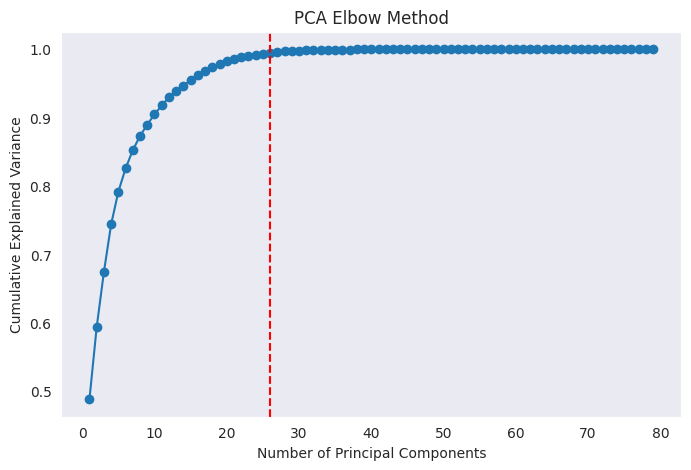

Optimal number of components: 26


In [8]:
pca = PCA()

pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [9]:
pca = PCA(n_components=elbow_point)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### LinearSVC

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


linear_svc = LinearSVC(dual=False, C=100, max_iter=10000, penalty='l2')

linear_svc.fit(X_train_pca, y_train)

y_pred = linear_svc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))


/home/fimichi/Studies/praca_inżynierska/repo/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

      BENIGN       0.99      0.91      0.95    158976
         Bot       0.10      0.83      0.18       590
        DDoS       0.98      1.00      0.99     38408
         DoS       0.91      0.98      0.94     75799
  FTPPatator       0.91      1.00      0.95      2381
    PortScan       0.99      1.00      0.99     47679
  SSHPatator       0.82      1.00      0.90      1769
   WebAttack       0.32      0.89      0.47       654

    accuracy                           0.95    326256
   macro avg       0.75      0.95      0.80    326256
weighted avg       0.97      0.95      0.96    326256



### SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


svc = SVC(C=10, gamma=0.1, kernel='poly')

svc.fit(X_train_pca, y_train)

y_pred = svc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))


              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00    158976
         Bot       0.77      0.99      0.87       590
        DDoS       1.00      1.00      1.00     38408
         DoS       0.99      1.00      1.00     75799
  FTPPatator       0.99      1.00      1.00      2381
    PortScan       1.00      1.00      1.00     47679
  SSHPatator       0.95      1.00      0.97      1769
   WebAttack       0.82      0.99      0.90       654

    accuracy                           1.00    326256
   macro avg       0.94      1.00      0.97    326256
weighted avg       1.00      1.00      1.00    326256



### DecisionTreeClassifier

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

decision_tree = DecisionTreeClassifier(criterion='log_loss', max_depth=14, max_features=None, min_samples_leaf=8, min_samples_split=16, splitter='best')

decision_tree.fit(X_train_pca, y_train)

y_pred = decision_tree.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))


              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99    158976
         Bot       0.77      0.99      0.86       590
        DDoS       0.99      1.00      1.00     38408
         DoS       0.98      0.99      0.99     75799
  FTPPatator       0.97      1.00      0.98      2381
    PortScan       1.00      1.00      1.00     47679
  SSHPatator       0.92      0.99      0.95      1769
   WebAttack       0.78      0.97      0.86       654

    accuracy                           0.99    326256
   macro avg       0.93      0.99      0.95    326256
weighted avg       0.99      0.99      0.99    326256



### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, p=4, weights='distance')

knn.fit(X_train_pca, y_train_encoded)

y_pred = knn.predict(X_test_pca)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(classification_report(y_test, y_pred_labels, target_names=np.unique(y_test)))



              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00    158976
         Bot       0.61      0.99      0.75       590
        DDoS       1.00      1.00      1.00     38408
         DoS       0.99      1.00      1.00     75799
  FTPPatator       0.99      1.00      1.00      2381
    PortScan       1.00      1.00      1.00     47679
  SSHPatator       0.96      1.00      0.98      1769
   WebAttack       0.88      0.99      0.93       654

    accuracy                           1.00    326256
   macro avg       0.93      1.00      0.96    326256
weighted avg       1.00      1.00      1.00    326256



### SDGClassifier

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

sgd = SGDClassifier(random_state=42)

sgd.fit(X_train_pca, y_train)

y_pred = sgd.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))


              precision    recall  f1-score   support

      BENIGN       0.99      0.92      0.95    158976
         Bot       0.09      0.85      0.16       590
        DDoS       1.00      1.00      1.00     38408
         DoS       0.92      0.98      0.95     75799
  FTPPatator       0.94      0.99      0.96      2381
    PortScan       1.00      0.99      1.00     47679
  SSHPatator       0.88      0.98      0.93      1769
   WebAttack       0.36      0.85      0.51       654

    accuracy                           0.95    326256
   macro avg       0.77      0.95      0.81    326256
weighted avg       0.97      0.95      0.96    326256



In [16]:
import pickle as pkl
with open("../app/ml_model/multi_linear_svc.pkl", 'wb') as f:
    pkl.dump(linear_svc, f)

with open("../app/ml_model/multi_svc.pkl", 'wb') as f:
    pkl.dump(svc, f)

with open("../app/ml_model/multi_decision_tree.pkl", 'wb') as f:
    pkl.dump(decision_tree, f)

with open("../app/ml_model/multi_knn.pkl", 'wb') as f:
    pkl.dump(knn, f)

with open("../app/ml_model/multi_sgd.pkl", 'wb') as f:
    pkl.dump(sgd, f)